# Home location Prediction

In this notebook, we will train several models over the Foursquare training dataset. We will also predict home locations of users in both Gowalla and Brightkite datasets using the best model 

# 1. Loading libraries

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,precision_score,recall_score

from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

from sklearn.ensemble import RandomForestClassifier

import joblib
from metrics import *

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the privat

# 2. Importing Training, Gowalla and Brighkite datasets

## 2.1. Importing training data

The training dataset consits of features extracted from the Foursqure checkin dataset. We computed them in `Feature_engineering.ipynb`

In [2]:
df_training=pd.read_csv("data/training_dataset.csv",index_col = 0)
df_training.head()

,user,CR,MR,EDR,EIDR,PR,RPR,Is_home,lat,lon,country
0,19,0.756158,0.846154,0.777027,0.772414,0.821211,0.801806,True,38.652989,-73.973113,US
1,19,0.056650,0.000000,0.054054,0.055172,0.022950,0.037273,False,40.725046,-73.992639,US
2,19,0.059113,0.000000,0.114865,0.117241,0.026504,0.026315,False,40.726305,-73.984104,US
3,19,0.036946,0.000000,0.013514,0.013793,0.024816,0.024017,False,40.724191,-73.997563,US
4,19,0.032020,0.000000,0.013514,0.013793,0.024730,0.026114,False,40.722940,-73.995724,US


## 2.2. Importing Gowalla Features 

Gowalla features are also computed in `Feature_engineering.ipynb`. We just load them here.

In [3]:
df_gowalla_features = pd.read_csv("data/gowalla_checkin_features.csv",index_col = 0)
df_gowalla_features.head()

,user,CR,MR,EDR,EIDR,PR,RPR,lat,lon
0,0,0.725962,0.894737,1.0,1.0,0.748403,0.800407,34.862264,-98.091842
1,0,0.110577,0.000000,0.0,0.0,0.071980,0.051105,30.269103,-97.749395
2,0,0.062500,0.000000,0.0,0.0,0.056549,0.048330,30.267910,-97.749312
3,0,0.033654,0.017544,0.0,0.0,0.035480,0.027163,30.244860,-97.757163
4,0,0.028846,0.000000,0.0,0.0,0.038535,0.035271,30.264854,-97.743845


## 2.3. Importing Brightkite Features

Similarely, we load Brightkite features

In [4]:
df_brightkite_features = pd.read_csv("data/brightkite_checkin_features.csv",index_col = 0)
df_brightkite_features.head()

,user,CR,MR,EDR,EIDR,PR,RPR,lat,lon
0,0,0.285204,0.277950,1.0,1.0,0.420218,0.241797,39.693950,-98.427854
1,0,0.011437,0.021739,0.0,0.0,0.005258,0.020780,39.891383,-105.070814
2,0,0.076483,0.141304,0.0,0.0,0.015565,0.054985,39.891120,-105.068526
3,0,0.042888,0.013975,0.0,0.0,0.017623,0.023467,39.750728,-104.999579
4,0,0.012152,0.006211,0.0,0.0,0.015682,0.007052,39.752790,-104.996794


# 3. Exploring location distributions
- We begin by exploring the location distributions for three different datasets : `training_df`,`df_gowalla_features`,`df_brightkite_features`
- We will use jointplots and will try to find similarities between the frames.

## 3.1. Training Dataset

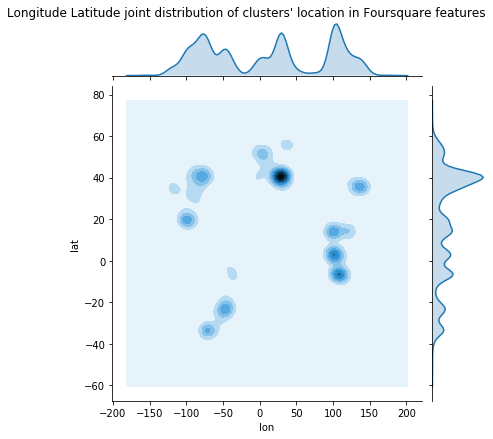

In [5]:
sns.jointplot(data = df_training, y = 'lat', x = 'lon', kind="kde")
plt.title('Longitude Latitude joint distribution of clusters\' location in Foursquare features',\
          loc='right',pad=70)
plt.show()

We can see that Foursquare features are distributed over all the world with a high concentration in northen american, european and austrialian continents.

## 3.2. Gowalla and Brighkite Features
- Now, we do the same work with the original datasets we were provided : the gowalla dataset and the brightkite dataset.

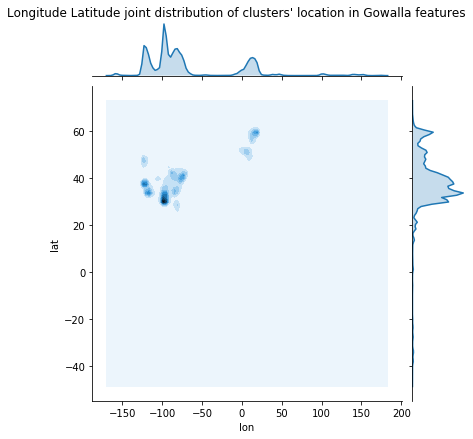

In [6]:
sns.jointplot(data = df_gowalla_features, y = 'lat', x = 'lon', kind="kde")
plt.title('Longitude Latitude joint distribution of clusters\' location in Gowalla features',\
          loc='right',pad=70)
plt.show()

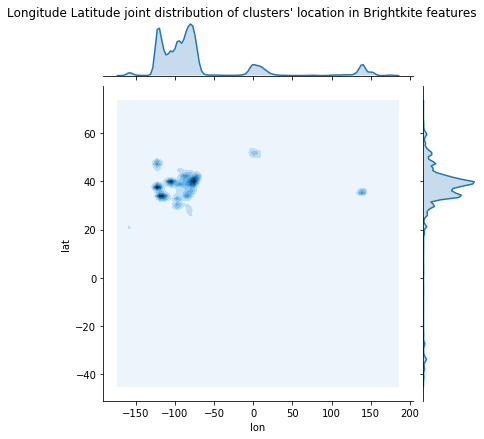

In [7]:
sns.jointplot(data = df_brightkite_features, y = 'lat', x = 'lon', kind="kde")
plt.title('Longitude Latitude joint distribution of clusters\' location in Brightkite features',\
          loc='right',pad=70)
plt.show()

- Here, we can clearly see the features' locations for both Gowalla and Brightkite datasets are concentrated in northen america and more precisely in the US.  
- Intuitively, to have the best fitting to both Gowalla and Brightkite datasets, we train our model only on check-ins located in the US : 
        - We filter the foursquare dataset by country and keep only US. 
        - Train our model
- We will try to do both methods and compare accuracy

# 4. Home Location Prediction:

## 4.1. Prediction on the whole dataset:

### 4.1.1. Splitting Data:

Here we define a function that splits the dataset into training validation and testing. We can use SMOTE upsampling and also standerdize the data. The testing set is not upsampled.

In [8]:
def splitting_data(df_training, country = None, upsampling = True, standerdize = True ):
    """
    function to split our data into a training set, a validation set and a test set
    Inputs:
        - df_training:dataset used for training
        - country : string : specify the abbreviation of countries : 2 Maj letters
                    if set to None : take the whole dataset
        - upsampling : choose to upsample the trainig set or not
        - standerdize : standardise the dataset (features only not the result)
        
    Outputs:
        - X_train : training features
        - y_train : training results
        - X_val : validation features
        - y_val : validation results
        - X_test : test features
        - y_test : test results
        - scaler : scaler that was used to normalize data
    """
    if country:
        df_training = df_training.loc[df_training.country == country]
    
    #test dataframe : 10% of the whole dataframe
    df_test = df_training.sample(frac = 0.1)
    df_training = df_training[~df_training.index.isin(df_test.index)]
    
    #X,y are the training data , X : features, y :results
    X=df_training[['CR','MR','EDR','EIDR','PR','RPR']].values
    y=df_training['Is_home'].values
    
    #set scaler and standaridize data if the user wants to
    if standerdize:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
    else:
        scaler = None
    
    #generate new features if the user wants to upsample
    if upsampling:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    
    #split data into validation and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    #get test sets
    X_test = df_test[['CR','MR','EDR','EIDR','PR','RPR']].values
    y_test = df_test['Is_home'].values
    
    if scaler is not None:
        #scale the test features the same way that was done for the training and validation ones
        X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

In [9]:
# Split data
X_train, y_train, X_val, y_val, X_test, y_test, scaler = splitting_data(df_training)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 4.1.2. Training Support Vector Machine Classifier (SVM classifier)
Let's train a Support vector classifier as suggested in the paper `Fine-scale prediction of people's home location using social media footprints`

In [10]:
clf_svc = SVC(kernel='linear',verbose=True,class_weight='balanced')
clf_svc.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', kernel='linear', verbose=True)

In [11]:
y_pred = clf_svc.predict(X_test) > 0.5

In [12]:
print('with this SVM Classifier model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

with this SVM Classifier model, we find and f1 score of 0.6635543106131342 on the test set


In [13]:
joblib.dump(clf_svc, 'models/SVC_all.pkl')

['models/SVC_all.pkl']

### 4.1.3. Training a Neural Network Classifier

Now, let's try a NN classifier

In [14]:
# Building Model
model = Sequential([
    Dense(60, input_shape = (X_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(40, activation = 'relu'),
    Dropout(0.5),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

# show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1230      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

In [15]:
# Fit the model over the 
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=10)

Train on 207796 samples, validate on 51950 samples
Epoch 1/20
207796/207796 [==============================] - 32s 154us/step - loss: 0.4536 - f1_m: 0.7966 - val_loss: 0.3795 - val_f1_m: 0.8060
Epoch 2/20
207796/207796 [==============================] - 31s 151us/step - loss: 0.4291 - f1_m: 0.8130 - val_loss: 0.3771 - val_f1_m: 0.8325
Epoch 3/20
207796/207796 [==============================] - 31s 148us/step - loss: 0.4269 - f1_m: 0.8074 - val_loss: 0.3791 - val_f1_m: 0.8318
Epoch 4/20
207796/207796 [==============================] - 31s 148us/step - loss: 0.4265 - f1_m: 0.8111 - val_loss: 0.3774 - val_f1_m: 0.8112
Epoch 5/20
207796/207796 [==============================] - 31s 148us/step - loss: 0.4264 - f1_m: 0.8075 - val_loss: 0.3725 - val_f1_m: 0.8154
Epoch 6/20
207796/207796 [==============================] - 31s 151us/step - loss: 0.4263 - f1_m: 0.8060 - val_loss: 0.3743 - val_f1_m: 0.8187
Epoch 7/20
207796/207796 [==============================] - 31s 147us/step - loss: 0.4255 -

In [16]:
model.save('models/NN_clf_all')

In [17]:
y_pred_NN=model.predict(X_test)

In [18]:
y_pred =y_pred_NN.flatten() > 0.5

In [19]:
print('with this Neural network model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

with this Neural network model, we find and f1 score of 0.6061665210335789 on the test set


In [20]:
y_pred.astype(int)

array([0, 1, 0, ..., 0, 0, 0])

### 4.1.4. Random forest classifier:

In [21]:
clf_RF = RandomForestClassifier(n_estimators= 20, max_depth=None, random_state=0,criterion='entropy',
                             class_weight='balanced', verbose=True)

In [22]:
clf_RF.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   12.4s finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=20, random_state=0, verbose=True)

In [23]:
y_pred = clf_RF.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


In [24]:
print('with this Random forest model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

with this Random forest model, we find and f1 score of 0.6417095616908439 on the test set


In [25]:
joblib.dump(clf_RF, 'models/RF_all.pkl')

['models/RF_all.pkl']

In [27]:
joblib.dump(scaler,'models/scaler_all.pkl')

['models/scaler_all.pkl']

### 4.1.4. Discussion:
- After running our models on all the data, we observe that:   
1) The f1 score for all models is between 0.6 and 0.7 .   
2) The SVM Classifier performs better than the two other models (f1 score of 0.66)  
3) Our Neural Network performs the worst on the test set with an f1 score of 0.61.  

- We now test our models on check-ins only localized in the USA

## 4.2. Prediction on only USA:
- We do the same work we did previously but working only with USA
- We will use the variables used before in order to preserve memory

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler = splitting_data(df_training, country='US')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 4.2.1. Training Support Vector Machine Classifier (SVM classifier)

In [29]:
#Since we have less data, we can use a degree 3 SVM
clf_svc = SVC(kernel='linear',verbose=True,class_weight='balanced')
clf_svc.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', kernel='linear', verbose=True)

In [30]:
joblib.dump(clf_svc, 'models/SVC_USA.pkl')

['models/SVC_USA.pkl']

In [31]:
y_pred = clf_svc.predict(X_test) > 0.5

In [32]:
print('with this SVM Classifier model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

with this SVM Classifier model, we find and f1 score of 0.6932084309133489 on the test set


### 4.2.2. Training a Neural Network Classifier

The f1 metric stays the same, the architecture of the Neural Network too

In [33]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=10)

Train on 29896 samples, validate on 7474 samples
Epoch 1/20
29896/29896 [==============================] - 6s 185us/step - loss: 0.4163 - f1_m: 0.8026 - val_loss: 0.3577 - val_f1_m: 0.8252
Epoch 2/20
29896/29896 [==============================] - 5s 172us/step - loss: 0.4167 - f1_m: 0.8098 - val_loss: 0.3588 - val_f1_m: 0.8330
Epoch 3/20
29896/29896 [==============================] - 6s 184us/step - loss: 0.4186 - f1_m: 0.8031 - val_loss: 0.3640 - val_f1_m: 0.8290
Epoch 4/20
29896/29896 [==============================] - 5s 156us/step - loss: 0.4146 - f1_m: 0.7975 - val_loss: 0.3684 - val_f1_m: 0.8321
Epoch 5/20
29896/29896 [==============================] - 5s 160us/step - loss: 0.4162 - f1_m: 0.8033 - val_loss: 0.3611 - val_f1_m: 0.8349
Epoch 6/20
29896/29896 [==============================] - 5s 164us/step - loss: 0.4165 - f1_m: 0.8046 - val_loss: 0.3555 - val_f1_m: 0.8366
Epoch 7/20
29896/29896 [==============================] - 5s 165us/step - loss: 0.4152 - f1_m: 0.8032 - val_los

In [34]:
model.save('models/NN_clf_USA')

In [35]:
y_pred_NN=model.predict(X_test)

In [36]:
y_pred =y_pred_NN.flatten() > 0.5

In [37]:
print('with this Neural network model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

with this Neural network model, we find and f1 score of 0.6872852233676976 on the test set


In [38]:
y_pred.astype(int)

array([0, 0, 0, ..., 1, 0, 0])

### 4.2.3. Random forest classifier:

In [39]:
clf_RF = RandomForestClassifier(n_estimators= 20, max_depth=None, random_state=0,criterion='entropy',
                             class_weight='balanced', verbose=True)

In [40]:
clf_RF.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=20, random_state=0, verbose=True)

In [42]:
y_pred = clf_RF.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [43]:
print('with this Random forest model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

with this Random forest model, we find and f1 score of 0.6783216783216783 on the test set


In [44]:
joblib.dump(clf_RF, 'models/RF_USA.pkl')

['models/RF_USA.pkl']

In [45]:
joblib.dump(scaler,'models/scaler_all.pkl')

['models/scaler_all.pkl']

### 4.2.4. Discussion :
- After running our models on the USA data, we observe that:   
1) The f1 score for all models is between 0.67 and 0.70 .  
2) The three models gave us near results.  
3) The SVM Classifier performs slightly better than the two others (f1 score of 0.69)  


## 4.3. Conclusion:
- The models perform generally better after restricting the dataframes to just check-ins made in the united states.
- This can be explained by the fact that the social behaviour is different around the world. Working on just a country reduces the number of parameters to be taken into account and therefore lets the models perform better. We can make the hypothesis that if we restrained our work to just some states (New York or Chicago for example), our f1 score would become even better.
- On our models, we could have improved them if we had more time and computational power. For example, we could have tried to fit a polynomial SVM Classifier (we just used a linnear one in this study). Moreover, we could have tried other architectures for the Neural Network to improve its performance. Finally, we could have tried doing the random forest with other parameters.